In [43]:
import itertools

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tokenizer

df = pd.read_csv("data.csv", dtype="str")
df["id"] = [row.rec_id.split("-")[1] for row in df.itertuples()]


FIELDS = [
    'first_name',
    'last_name',
    #'city',
    #'date_of_birth',
    #'gender',
    'state',
]

NUMBER_FIELDS = [
    'social_security_number',
    'phone_number',
]

ALL_FIELDS = FIELDS + NUMBER_FIELDS

L = 1000
kn = 150
EPS = [1, 1.5, 2, 3, 4]

DICES = []

for eps in EPS:
    print(f"eps={eps}")
    
    for field in FIELDS:
        print(field)
        df[f"token_{field}"] = df[field].apply(lambda name: tokenizer.tokenize_name(L, kn, eps, str(name), prefix=f"{field}:"))
        
    for field in NUMBER_FIELDS:
        print(field)
        df[f"token_{field}"] = df[field].apply(lambda name: tokenizer.tokenize_number(L, kn, eps, str(name), prefix=f"{field}:"))

    df["joined_bf"] = [np.array(list(itertools.chain(*[getattr(row, f"token_{field}") for field in FIELDS + NUMBER_FIELDS]))) for row in df.itertuples()]
    
    DICES.append(pd.DataFrame.from_records(
        [
            dict(
                [
                    ("id1", a.rec_id),
                    ("id2", b.rec_id),
                    ("dice", tokenizer.dice(a.joined_bf, b.joined_bf)),
                    ("same", a.id == b.id),
                ]
                + [
                    (
                        f"dice_{field}",
                        tokenizer.dice(getattr(a, f"token_{field}"), getattr(b, f"token_{field}")),
                    )
                    for field in ALL_FIELDS
                ]
            )
            for a, b in itertools.combinations(df.itertuples(), 2)
        ]
    ))


eps=1
first_name
last_name
state
social_security_number
phone_number
eps=1.5
first_name
last_name
state
social_security_number
phone_number
eps=2
first_name
last_name
state
social_security_number
phone_number
eps=3
first_name
last_name
state
social_security_number
phone_number
eps=4
first_name
last_name
state
social_security_number
phone_number


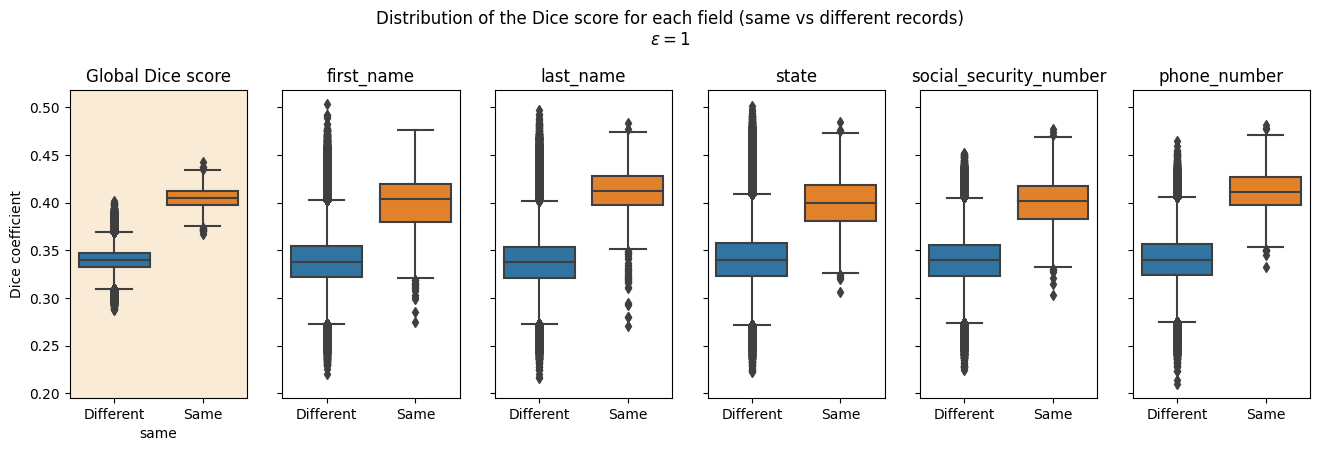

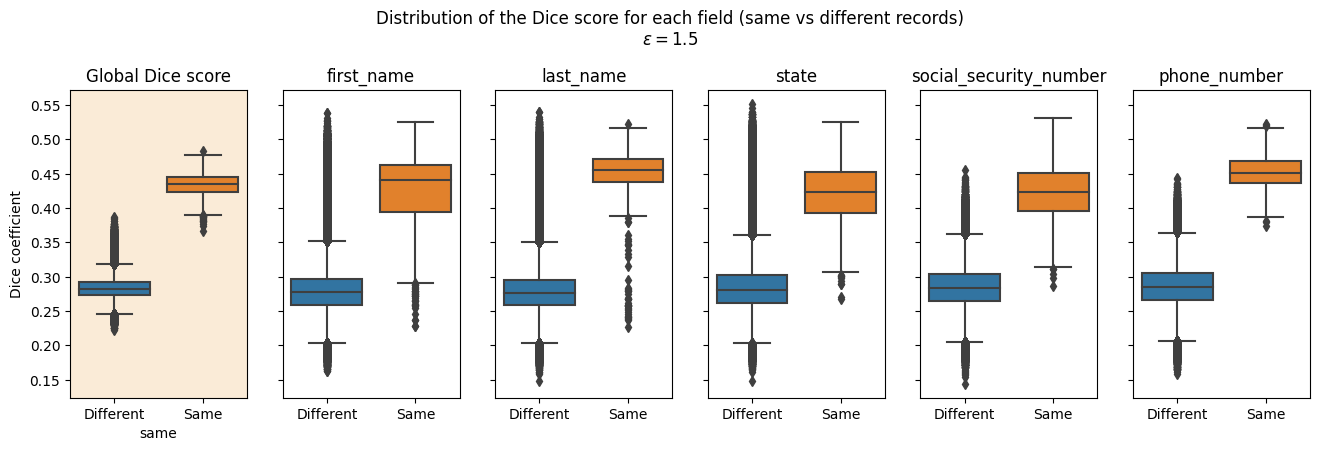

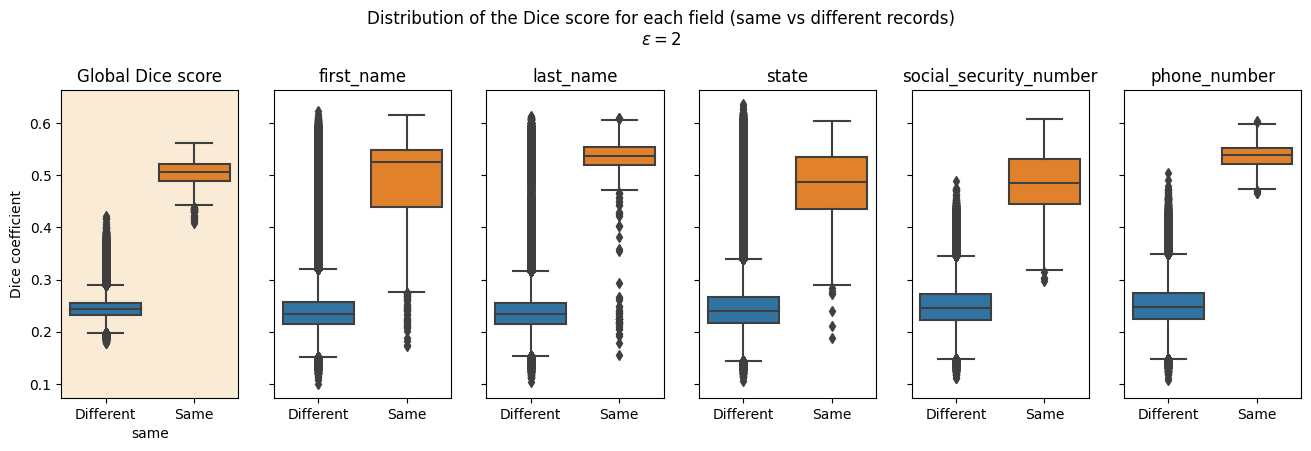

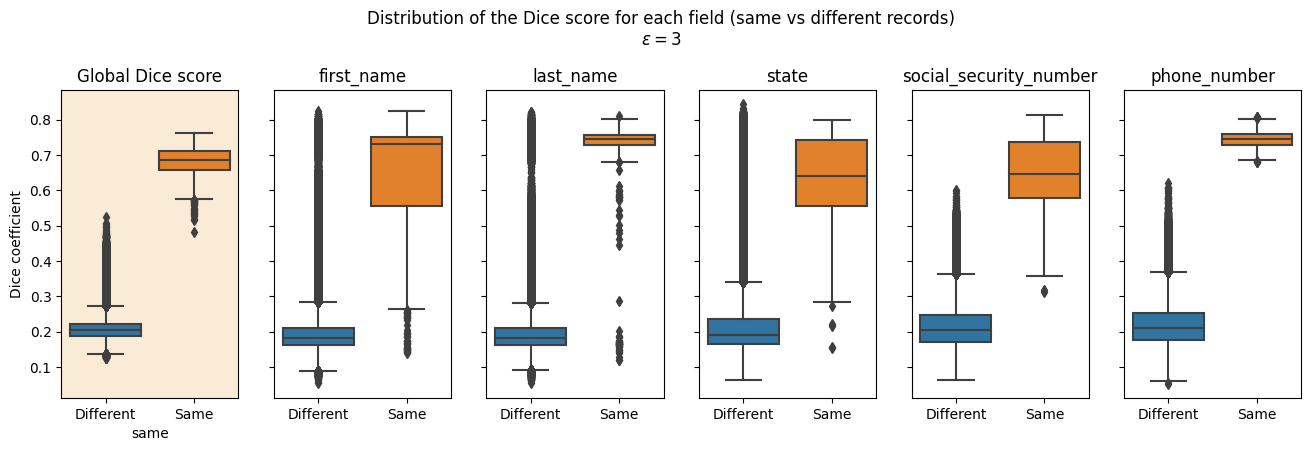

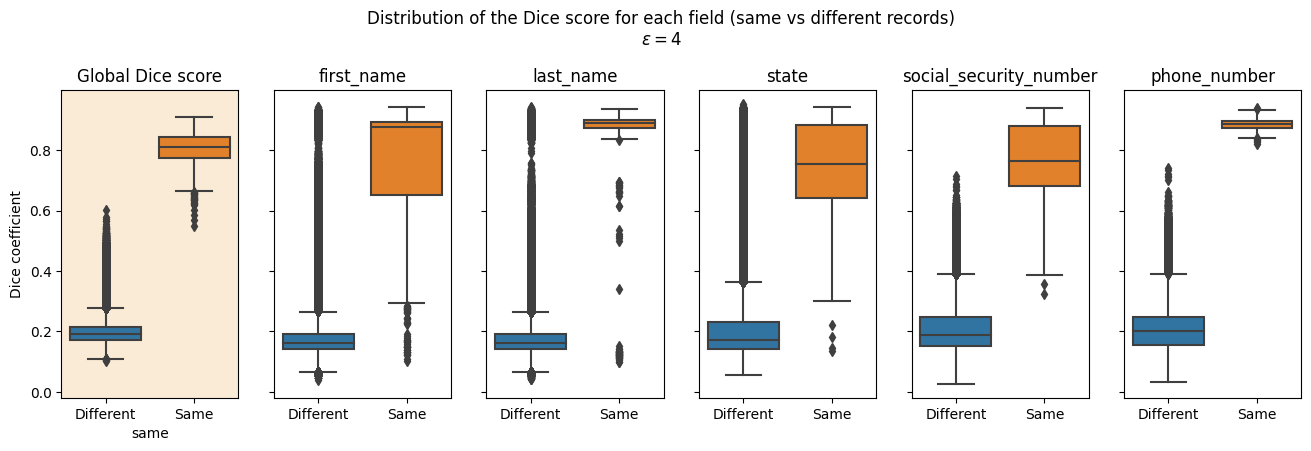

In [47]:
for eps, dices in zip(EPS, DICES):
    # Dice score distribution for each field
    fig, axs = plt.subplots(1, 1+len(ALL_FIELDS), sharex=True, sharey=True, figsize=(16, 4))
    sns.boxplot(x="same", y=f"dice", data=dices, ax=axs[0])
    axs[0].set_title("Global Dice score")
    axs[0].set_facecolor('antiquewhite')
    for ax, field in zip(axs[1:], ALL_FIELDS):
        sns.boxplot(x="same", y=f"dice_{field}", data=dices, ax=ax)
        ax.set_title(field)
        ax.set_ylabel("")
        ax.set_xticklabels(["Different", "Same"])
        ax.set_xlabel("")
    axs[0].set_ylabel("Dice coefficient")
    fig.suptitle(f"Distribution of the Dice score for each field (same vs different records)\n$\epsilon={eps}$", y=1.08)
    plt.show()

In [74]:
# Import precision and recall
from sklearn.metrics import precision_score, recall_score

for eps, dices in zip(EPS, DICES):
    THRESHOLD_GLOBAL_DICE = np.percentile(dices[dices.same].dice, 3)

    # Protocol 1: global Dice score
    dices["protocol1"] = dices.dice > THRESHOLD_GLOBAL_DICE

    # Protocol 2: all but 1 field with Dice score > 0.9x
    THRESHOLD = 0.7*THRESHOLD_GLOBAL_DICE
    dices["protocol2"] = (np.array([
        [dices[f"dice_{field}"] > THRESHOLD for field in ALL_FIELDS]
    ]).sum(axis=1) >= len(ALL_FIELDS) - 1)[0]

    # Protocol 3: all but 2 fields with Dice score > 0.9x
    THRESHOLD = 0.85*THRESHOLD_GLOBAL_DICE
    dices["protocol3"] = (np.array([
        [dices[f"dice_{field}"] > THRESHOLD for field in ALL_FIELDS]
    ]).sum(axis=1) >= len(ALL_FIELDS) - 2)[0]

    # Comparison of the protocols
    comparison = pd.DataFrame.from_records([
        {
            "Protocol": f"Protocol {i}",
            "Precision": precision_score(dices.same, dices[f"protocol{i}"]),
            "Recall": recall_score(dices.same, dices[f"protocol{i}"]),
            "Epsilon": eps,
        } for i in range(1, 4)
    ], index="Protocol".split())
    print(comparison)


            Precision    Recall  Epsilon
Protocol                                
Protocol 1   0.671303  0.969494        1
Protocol 2   0.000672  1.000000        1
Protocol 3   0.000767  1.000000        1
            Precision    Recall  Epsilon
Protocol                                
Protocol 1   1.000000  0.969494      1.5
Protocol 2   0.003029  1.000000      1.5
Protocol 3   0.554684  1.000000      1.5
            Precision    Recall  Epsilon
Protocol                                
Protocol 1   1.000000  0.969494        2
Protocol 2   0.967509  0.997024        2
Protocol 3   0.997033  1.000000        2
            Precision    Recall  Epsilon
Protocol                                
Protocol 1   1.000000  0.969494        3
Protocol 2   1.000000  0.994048        3
Protocol 3   0.999255  0.998512        3
            Precision    Recall  Epsilon
Protocol                                
Protocol 1   1.000000  0.969494        4
Protocol 2   1.000000  0.991815        4
Protocol 3   0.9

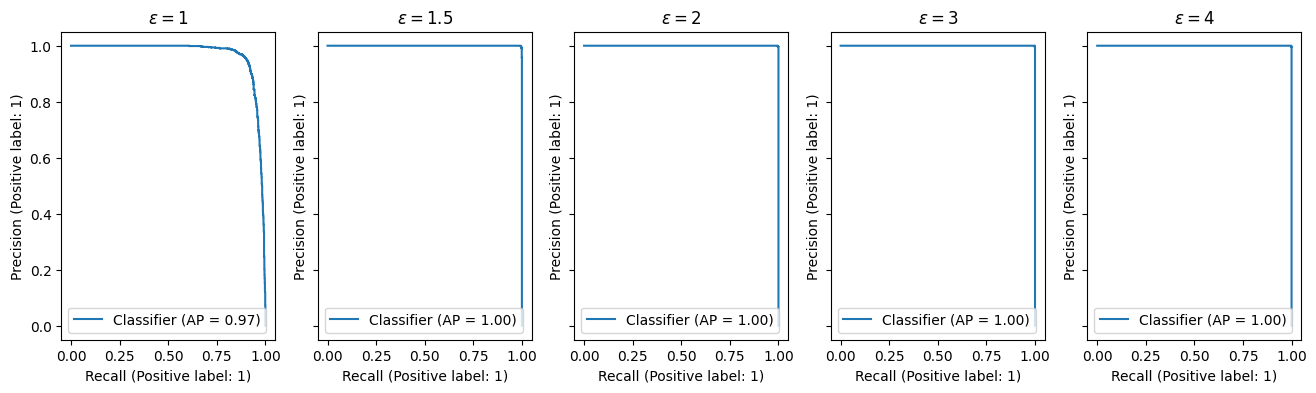

In [70]:
# Import precision and recall
from sklearn.metrics import PrecisionRecallDisplay

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(16, 4))

for ax, (eps, dices) in zip(axs, zip(EPS, DICES)):
    PrecisionRecallDisplay.from_predictions(dices.same, dices.dice, ax=ax)
    ax.set_title(f"$\epsilon={eps}$")
    